# Spinodal Decomposition (Part I)


## Introduction

In this notebook, we analyze the spinodal decomposition model. First, we load and present the data, test various latent space representations, and analyze the optimal number of clusters. Then, we adopt the learning by confusion scheme to determine the most likely transition threshold between classes.


### Scope of the work

 1. We load and present the input data.
 2. We describe a specific class of morphologies that consists of connected, spanning-clusters of a macroscopic size.
 3. We map the input to the latent (feature) space.
 4. We cluster the morphologies; we analyze the optimal number of clusters.
 5. We use the learning-by-confusion scheme, to determine the threshold values of parameters for which we can observe the transition between two main morphology classes.


### Part II

In the 2nd notebook we focus on the aspects of semi-supervised learning.
 - First, we cluster the data and we select the most representative instances. Next, we propagate labels from the cluster centroids to build a clean training dataset.
 - We demonstrate how to train a classifier that is capable of detecting the spanning-clusters without explicit access to the true labels.


### Part III

In the 3rd notebook we focus on training a predicting models.
 - We train a classifier, to predict the resulting morphology from the initial few frames of the simulation.
 - We train a regression model, to predict the initial parameters from the final simulation output.


### The Background

 - We have training and test data generated with a help of a classical, resource-intensive simulation.
 - Each simulation describes evolution of two phases.
 - We are interested in learning the final morphology.
 - We have three different (initial) parameters that we can control: mobility of phase A, `mobA`, mobility of phase B, `mobB`, and phase fraction, `frac`.
 
 
### Motivation

 - **Goal 1:** We would like to learn if the morphologies can be logically grouped into a number of distinctive classes. If yes, we would like to create a morphology map - or in other words - we would like to map the initial conditions to the expected morphology type.
 - **Goal 2:** We would like to train a model to predict the expected morphology type from the initial (few) frames of the classical simulation. This can have practical use. For example:
   - It would allow for a faster screening of the parameter space.
   - We could build a detector that can flag, in the early stage of the simulation, if our system is likely to terminate in the desirable state (if the resulting morphology is likely to be desirable or not). Such system could terminate simulations that are likely to end up in non-interesting state, decreasing waste of the computational resources.
   
In this notebook, we focus on the first goal.

### Library Imports

We pre-load all the libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    matplotlib                        3.3.0
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import json
import os
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import numpy
import pandas
import scipy
import skimage.measure
import sklearn.cluster
import sklearn.decomposition
import sklearn.manifold
import sklearn.metrics
import tensorflow
import tensorflow_hub

# Graphic libraries
import IPython.display
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Section 1: The Input Data

We load the input data - results of a classical simulation that solves the Cahn-Hilliard equation.

The original simulations were saved as 101x512x512 dimensional numpy arrays, with `float64` numbers that range from around -1.05 to +1.05. However, in order to save the space, we casted the numbers to `float16`. Additionally, to make the input more similar to the input of some popular CNN architectures, we changed the dimensions of each frame from 512x512 to 256x256.

The compression was performed by the following code,

```python
    assert original_data.dtype == 'float64' 
    assert original_data.shape == (4998, 101, 512, 512, 1)
    
    last_frame = original_data[:,-1]
    resized_data = skimage.measure.block_reduce(last_frame, (1, 2, 2, 1), numpy.mean)
    resized_data = resized_data.astype('float16')
    
    assert resized_data.dtype == 'float16' 
    assert resized_data.shape == (4998, 256, 256, 1)
```

Each 2x2 block of pixels was replaced by the mean value and then the numerical precision was reduced from `float64` to `float16`. We believe that those modifications are justified, as the small fluctuations of the pixel brightness seems to not encode any important information. The phase A is encoded by numbers close to +1 (cf. the yellow phase below) and phase B is encoded by numbers close to -1 (cf. the purple phase below). The meaningful information is if the pixels are positive or negative, not the exact values in each pixel. The information about the size and shape of the specific regions should be the most important. The only places where the phase value might be close to 0 are points on the border of the "bubbles" (see below).

There was originally 5000 training and 500 test simulations (generated for different initial parameters; the initial conditions were selected randomly from uniform distributions). However, we found that 2 training simulations were corrupted. Therefore, we will operate on 4998 training and on 500 testing examples. Later, we will select 1000 training examples as our validation dataset, so the effective size of our training set will be 3998.

The input data have discrete translational symmetry (the input data is represented on a torus; we have periodic-boundary conditions both up-down and left-right).

### Data Location

All the input data can be found at the ISI server `effectbig03` in the `/data/mjabram/share/spinodal_decomposition` folder.

In [2]:
# If you run this notebook, change the path so it match location of your main data folder
DATA_PATH = '/raw/cah/shared/'

### Training Data

We load the training data. We use a dataset, that has only the last frame of the simulation.
For our convenience, we cast the data back from `float16` to `float32` (for example `imshow` method expect input as either `int32` or `float32`, `float16` input is not supported). However, this doesn't mean, that our accuracy of the input data increased to `float32`. We still have only about 4 significant digits per number.

In [3]:
# Load the training data
data = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000x_256f16.npy')).astype('float32')
data.shape, data.dtype

((4998, 256, 256, 1), dtype('float32'))

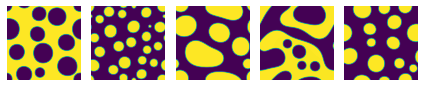

In [4]:
def plot_frames(data, *arr, cmap='viridis', title=None, axis=None):
    """Plot selected frames."""
    if title:
        print(title)
    fig, axes = plt.subplots(1, len(arr))
    for i, k in enumerate(arr):
        a = axes if len(arr) == 1 else axes[i]
        if not axis:
            a.axis('off');
        fig.tight_layout() 
        a.imshow(data[k], cmap=cmap)
    plt.show()


# Plot last frames from the first, second, third, 15th and the last simulation
plot_frames(data, 0, 1, 2, 14, -1)

(1.0400391, -1.0361328, -3.5966474e-05)

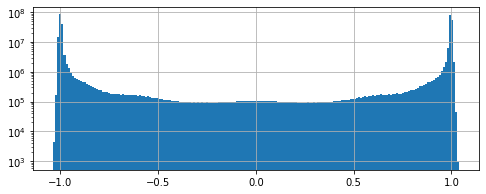

In [5]:
# Plot the distribution of the pixel values in the input data
fig, ax = plt.subplots()
pandas.Series(data.flatten()).hist(bins=200, figsize=(8, 3))
ax.set_yscale('log')

# Print the max, the min and the mean of that distribution
data.max(), data.min(), data.mean()

Most pixels have value either around +1 or -1 (mind that the graph is logarithmic in the y-axis). The input data are well balanced, the mean value of the pixels intensivity is around zero. This is consistent with our expectation, since the initial phase fraction was selected from an uniform distribution centered around zero.

We noticed, that the values above 1 and below -1 usually correspond to internal parts of the "bubbles" (see examples below). However, values below -1 or above 1 does not have any physical sense. We expect that values outside the `[-1, 1]` range values are a product of either a rounding errors in the classical simulation or are related to an incorrect normalization choice. Therefore, we standardized the data by replacing the values above 1 with one and below -1 with minus one. After that, we rescale the input to the `[0, 1]` range (see the code below).

Input Frames


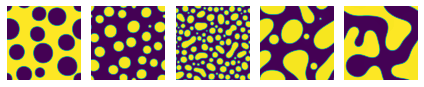

Regions > 1 (red)


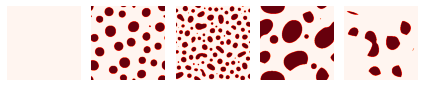

Regions < -1 (white)


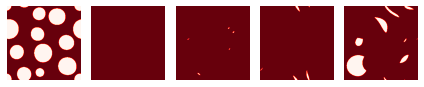

In [6]:
# Show regions where pixel values are > 1 and < -1
plot_frames(data, 0, 1, 17, 23, 32, title='Input Frames')
plot_frames(numpy.where(data > 1, 1, 0), 0, 1, 17, 23, 32, cmap='Reds', title='Regions > 1 (red)')
plot_frames(numpy.where(data < -1, 1, 0), 0, 1, 17, 23, 32, cmap='Reds_r', title='Regions < -1 (white)')

(0.0, 1.0, 0.49998206)

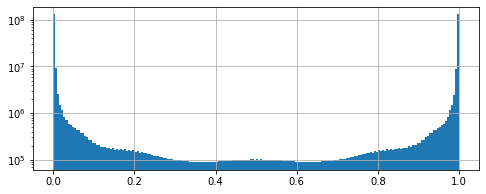

In [7]:
# Standarize the input data
data = numpy.where(data > 1, 1, data)
data = numpy.where(data < -1, -1, data)
data += 1
data /= 2

# Plot the distribution again (note, now the distribution is from 0 to 1)
fig, ax = plt.subplots()
pandas.Series(data.flatten()).hist(bins=200, figsize=(8, 3))
ax.set_yscale('log')
data.min(), data.max(), data.mean()

### Parameters

We load the initial parameters. There are three values for each simulation: the mobility of the phase A, `mobA`, the mobility of the phase B, `mobB`, and the phase fraction, `frac`.

The initial parameters were selected from uniform distributions. Mobility of the A and B phase were selected from `U(0, 100)`, while the phase fraction was selected from `U(-0.4, 0.4)`.

The phase fraction is (most likely) defined as `frac = phase A concentration - phase B concentration` with the constraint `phase A concentration + phase B concentration = 1`.

**Attention**, there is a small discrepancy between the input data and the parameter sheet (see below). For example, simulation no. 0 is denoted in the parameter sheet as having `frac=0.14997`, while the average pixel intensity gives value of `0.14112` (measured on the raw data) or `0.14252` (after the resolution and precision reduction, and after the extreme value clipping described above; where impact of the extreme value clipping had the most significant effect; the resolution reduction and `float16` casting had negligible impact). 

In [8]:
# Load the parameters
parameters = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000p_256f16.npy'))
parameters = pandas.DataFrame(data=parameters, columns=['mobA', 'mobB', 'frac'])
parameters

,mobA,mobB,frac
0,78.351394,88.578582,0.149971
1,37.781287,27.656161,-0.385097
2,52.531034,70.504555,-0.032220
3,94.929101,50.044347,-0.256615
4,88.876537,73.877391,0.070644
...,...,...,...
4993,67.035086,46.664670,-0.158747
4994,94.223735,98.272281,0.148099
4995,2.031358,43.635881,0.238011
4996,14.542157,0.946535,0.029123


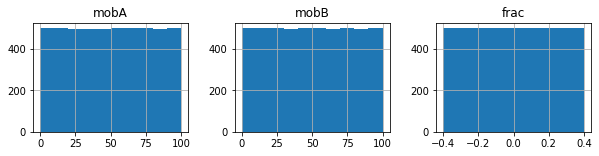

In [9]:
# Plot a histogram of parameter values
parameters.hist(figsize=(10, 2), layout=(1, 3))
plt.show()

In [10]:
# Show the discrepancy between the frac parameter and the average pixel intensity
# Note, that in our table, the simulations are counted from 0, while the original files
# had numbers starting from 1. Therefore 'all_data_1' is our "zero" simulation.
single_simulation = numpy.load(os.path.join(DATA_PATH, 'all_data_1.npy'))
intensity = single_simulation.sum(axis=(1, 2, 3))/512**2

print(f'Average pixel intensity (full size, float64)      : {intensity.mean()} +- {intensity.std()}')
print('Value from the parameter sheet:                   :', parameters.frac[0])
print('Average pixel intensity (after reduction+clipping):', 2*data[0].mean()-1)

Average pixel intensity (full size, float64)      : 0.14112361291215691 +- 1.4643876163778922e-12
Value from the parameter sheet:                   : 0.1499711181
Average pixel intensity (after reduction+clipping): 0.14252471923828125


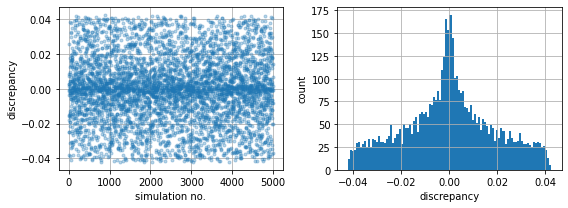

In [11]:
# show the discrepancy between the frac parameter and the average pixel intensity
average_intensity = 2*data.sum(axis=(1, 2, 3))/256**2 - 1
discrepancy = parameters.frac - average_intensity
histogram = pandas.Series(discrepancy.T)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(discrepancy, '.', alpha=0.3); axes[0].grid()
axes[0].set_xlabel('simulation no.'); axes[0].set_ylabel('discrepancy');
histogram.hist(ax=axes[1], bins=100)
axes[1].set_xlabel('discrepancy'); axes[1].set_ylabel('count');
fig.tight_layout()
plt.show()

**Summary:** We believe that the discovered discrepancy do not affect our analysis in any significant way. The error distribution seems symmetric, so in average, the error effects should cancels each other out. The important information is the shape of the structures and they are likely to not be affected, since positive phase is usually encoded by numbers close to 1 and negative phase is usually encoded by numbers close to -1.

## Section 2: The Spanning Clusters

Looking at the simulations, we can notice that there are two obvious classes: one where the positive phase is dominant (yellow background, purple "bubbles") and another where the negative phase is dominant (purple background, yellow "bubbles"). However, as we will see in moment, we have also cases, that can not be easily accounted to one of those two classes.

### Connectivity Data

We generated labels, checking if there is a path connecting pixels of one color from one edge to another edge. Specifically, we check if there is:
 - a vertical connection `v`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(0, k)` to `(n-1, k)`.
 - a horizontal connection `h`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(k, 0)` to `(k, n-1)`.
 
We checked those connections with respect to:
 - both, negative phase (denoted as `B` and depicted below as purple regions) and positive phase (denoted as `A` and depicted as yellow regions).
 - both, using and not-using the fact, that we have periodic boundary conditions (denoted below as `pbc`).

In [12]:
# Load and show the labels
connectivity = pandas.read_csv(os.path.join(DATA_PATH, 'cah_lastframe_train5000c_256f16.csv'))
connectivity

,pos,neg,pos_pbc,neg_pbc
0,hv,0,hv,0
1,0,hv,0,hv
2,0,hv,0,hv
3,0,hv,0,hv
4,hv,0,hv,0
...,...,...,...,...
4993,0,hv,0,hv
4994,hv,0,hv,0
4995,hv,0,hv,0
4996,0,0,hv,hv


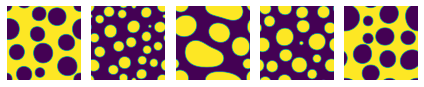

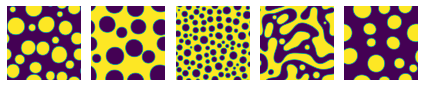

In [13]:
# Plot the first 5 and the last 5 examples
plot_frames(data, 0, 1, 2, 3, 4)
plot_frames(data, 4993, 4994, 4995, 4996, 4997)

Note, that if both `pos=hv` and `neg=0`, it indicates then the positive phase is dominant (yellow background, purple "bubbles"). The opposite situation is when `pos=0` and `neg=hv`, then the negative phase is dominant (purple background, yellow bubbles).

However, there are a couple of examples that can not be easily classified as horizontal (h) or vertical (v). One of them are the simulations no. 14, 4966 and 4996 (see below). We will call such examples _spanning clusters_ (SC).

Because we have periodic boundary conditions, those spanning clusters have _macroscopic_ size. The fact, that some cases were annotated as 0 in `pos` and `neg` but got non-zero value for `pos_pbc` and/or in `neg_pbc` usually means, that the spanning clusters are extended in the diagonal direction (see for example the simulation no. 2771).

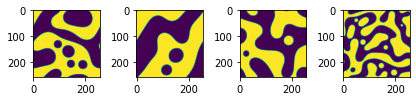

In [14]:
plot_frames(data, 14, 2771, 4966, 4996, axis=True)

In [15]:
# Mark "spaning clusters" (sc), dominant positive (+), and dominant negative (-) cases
connectivity['sc'] = [int(row.pos != 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['+'] = [int(row.pos == 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['-'] = [int(row.pos != 'hv' and row.neg == 'hv') for _, row in connectivity.iterrows()]
connectivity.tail()

,pos,neg,pos_pbc,neg_pbc,sc,+,-
4993,0,hv,0,hv,0,0,1
4994,hv,0,hv,0,0,1,0
4995,hv,0,hv,0,0,1,0
4996,0,0,hv,hv,1,0,0
4997,0,hv,0,hv,0,0,1


In [16]:
# Show the list of sc cases
connectivity[connectivity.sc == 1]

,pos,neg,pos_pbc,neg_pbc,sc,+,-
14,h,h,hv,h,1,0,0
38,v,v,v,v,1,0,0
40,v,v,hv,v,1,0,0
95,h,h,h,hv,1,0,0
160,0,h,hv,hv,1,0,0
...,...,...,...,...,...,...,...
4792,v,v,hv,v,1,0,0
4859,h,0,hv,hv,1,0,0
4935,h,h,hv,hv,1,0,0
4966,0,0,hv,hv,1,0,0


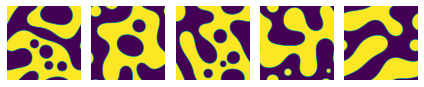

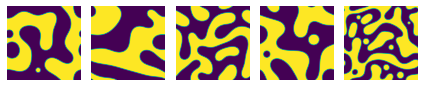

In [17]:
# Show some SC cases from the list above
plot_frames(data, 14, 38, 40, 95, 160)
plot_frames(data, 4792, 4859, 4935, 4966, 4996)

In [18]:
# Note, that thos outcomes happen for wide range of mobA and mobB parameter values.
parameters.iloc[[14, 38, 40, 95, 160, 4792, 4859, 4935, 4966, 4996]]

,mobA,mobB,frac
14,15.264899,84.923593,-0.010783
38,45.402531,49.222242,0.014210
40,29.788026,77.693817,-0.004745
95,54.556281,42.425424,0.005540
160,97.445514,54.991304,0.003702
4792,28.089231,61.198178,-0.011111
4859,74.987470,71.165329,0.020708
4935,5.723691,27.519657,-0.020191
4966,42.696784,32.601826,0.006820
4996,14.542157,0.946535,0.029123


**Summary:** The spanning clusters will become our central focus through this notebook. There are interesting, because they indicate a moment when the system switch from one main class of outcomes (phase A being connected; or in other words, the cases with purple "bubbles" on yellow background) to the second main class of outcomes (phase B being connected; yellow "bubbles" on purple background).

We can also interpret this transition in terms of changing "natural scale" of the system. Approaching the transition, the size of the microscopic structures increases to reach macroscopic level. That scaling resemble some aspects of the universal scaling known from statistical physics. In other words, the final outcome become independent of the independent of the dynamical details of the system.

## Section 3: The Feature Vectors (The Latent Space)

To create feature vector from an image, we can use one of several pre-trained models available from TensorFlow Hub, e.g.:
 - **ResNet V2** with 50 layers. The key difference with the V1 is the use of the batch normalization. The model was trained on the standard ImageNet-1k dataset (ILSVRC-2012-CLS). The feature vector has size `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other similar input sizes are also possible. See more at https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
 - **Inception V3**, trained on the iNaturalist 2017 dataset, after pre-training on ILSVRC-2012-CLS. The output vector has dimension `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other input sizes are possible (within limits), see more at https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4
 - **BiT ResNet-50** (standard), pre-trained on ImageNet-21k (also known as the "Full ImageNet"). The output vector has dimension `2048`. See more at https://tfhub.dev/google/bit/m-r50x1/1
 - **BiT ResNet-50 x3** (three times wider), pre-trained on ImageNet-21k (also known as the "Full ImageNet"). The output vector has dimension `6144`. See more at https://tfhub.dev/google/bit/m-r50x3/1
 - **BiT ResNet-101** (standard), pre-trained on ImageNet-21k (also known as the "Full ImageNet"). The output vector has dimension `2048`. See more at https://tfhub.dev/google/bit/m-r101x1/1

We selected the above models, to test if the particular choice of the network architecture matters in our clustering task. We tried to chose popular model architectures and we selected versions trained on different datasets, like ImageNet, Full ImageNet or iNaturalist. 

Note, that all those models require 3-channel input. Our input data have a single channel. We can, however, triple our output (each channel will have the same information).

In [19]:
# Triple the channel
data3 = numpy.repeat(data, 3, axis=-1)
data3.shape

(4998, 256, 256, 3)

### Feature Vectors Computation

We computed the feature vectors by running the following code (on RTX 2070 it takes about 5-10 minutes). If you want to run it yourself, uncomment the cells below.

```python
# Map input to the feature space using ResNet V2
m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4", trainable=False),
])
m.build([None, 256, 256, 3])

features1 = m.predict(data3)
```

```python
# Map input to the feature space using Inception V3
m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4", trainable=False),
])
m.build([None, 256, 256, 3])

features2 = m.predict(data3)
```

```python
# Map input to the feature space using BiT ResNet-50
m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r50x1/1", trainable=False),
])
m.build([None, 256, 256, 3])

features3 = m.predict(data3)
```

```python
# Map the input to the feature space using BiT ResNet-50 x3
m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r50x3/1", trainable=False),
])
m.build([None, 256, 256, 3])

features4 = m.predict(data3)
```

```python
# Map the input to the feature space using BiT ResNet-50
m = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/bit/m-r101x1/1", trainable=False),
])
m.build([None, 256, 256, 3])

features5 = m.predict(data3)
```

In [20]:
# Here, to save time, we will load the pre-computed feature vectors.
features1 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2.npy'))
features1.shape

(4998, 2048)

In [21]:
features2 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_InceptionV3.npy'))
features2.shape

(4998, 2048)

In [22]:
features3 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_MR50x1.npy'))
features3.shape

(4998, 2048)

In [23]:
features4 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_MR50x3.npy'))
features4.shape

(4998, 6144)

In [24]:
features5 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_MR101x1.npy'))
features5.shape

(4998, 2048)

### Feature Vectors Visualization

The features are not normalized. Some features reach values as large as 30 (see below). In other cases, the values seems to be limited only to small numbers (see the last example below).

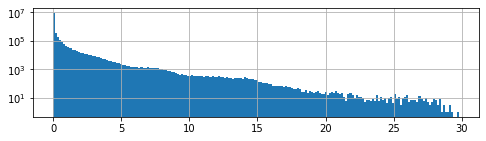

In [25]:
# Histogram for all feature values (the ResNet V2 case)
fig, ax = plt.subplots()
pandas.Series(features1.flatten()).hist(bins=200, figsize=(8, 2))
ax.set_yscale('log')

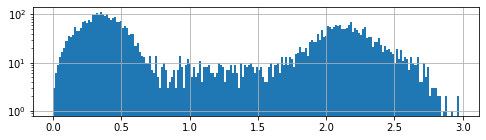

In [26]:
# Histogram for the values of the 6th feature (counting is form 0) out of 6144 for the ResNet 50x3 case
fig, ax = plt.subplots()
pandas.Series(features4[:,5].flatten()).hist(bins=200, figsize=(8, 2))
ax.set_yscale('log')

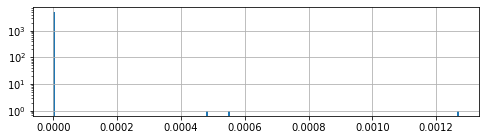

In [27]:
# Histogram for the values of the 8th feature out of 6144 (the ResNet 101x3 case)
fig, ax = plt.subplots()
pandas.Series(features4[:,8].flatten()).hist(bins=200, figsize=(8, 2))
ax.set_yscale('log')

### Feature Vectors Normalization

K-Means is very sensitive to the range of the input features. In many practical situations, it is advisable to scale all the input features before running the k-Means algorithm.

Another observation is, that it might be a good practice to first reduce the dimensionality of our feature vector before trying to cluster the instances. We operate in large-dimensional space (of 2048 or 6144 dimensions). When the number of dimensions is large, a randomly selected point in a hyper-dimensional cube has a large probability of being close to one of cube's wall. In other words, high-dimensional datasets are usually very sparse - the instances have very small probability of being close to each other. Many machine learning algorithms face a risk of overfitting to the training set in such conditions. Since any new instance will likely be far away from the training examples, the error or our projection can be significant. Therefore, in many practical applications, a dimensionality reduction is applied before clustering (cf. Aurélien Géron, _Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_, 2nd Edition", 2019, chapter 9).

Finally, we should remember that we used CNN models trained on pictures of real objects (like cats, dogs or plans). The feature vectors should still work for our purpose - with different features encoding specific patterns or visual characteristics. However, we might expect that at least some (if not majority) of those features might be irrelevant for our task. By applying e.g., PCA, we can take the most significant eigenvectors, while ignoring the rest.

Therefore, below we test the following three normalization scenarios:
 - (A), it is our control approach. We do not nothing and we use the raw feature vectors.
 - (B), we will use the PCA algorithm to reduce the dimensionality of the feature vectors (e.g. to such a dimension that 90% of variance is explained). Next, we will scale each feature independently, so it ranges from 0 to 1 across all simulations.
 - (C), we will normalize each feature vectors using `tanh`. In other words, we will apply `tanh` transformation feature-wise. In such a way, the features that were small will remain small; while the large values will be "squeezed" to values between 0 and 1. We will not reduce the dimensionality in this scenario.

In [28]:
# Prepare the first (A) set of features (no change).
featuresA = {
    'ResNetV2': features1,
    'IncepV3': features2,
    'MR50': features3,
    'MF50x3': features4,
    'MR101': features5
}

In [29]:
# Prepare the second (B) set of features (PCA + scalling).
def pca_then_scaling(features):
    """The second approach."""
    pca = sklearn.decomposition.PCA(n_components=0.90)
    reduced = pca.fit_transform(features)
    scalled = sklearn.preprocessing.normalize(reduced, norm='max', axis=0)
    print('shape:', scalled.shape)
    return scalled


featuresB = {
    'ResNetV2': pca_then_scaling(features1),
    'IncepV3': pca_then_scaling(features2),
    'MR50': pca_then_scaling(features3),
    'MF50x3': pca_then_scaling(features4),
    'MR101': pca_then_scaling(features5)
}

shape: (4998, 11)
shape: (4998, 51)
shape: (4998, 9)
shape: (4998, 12)
shape: (4998, 14)


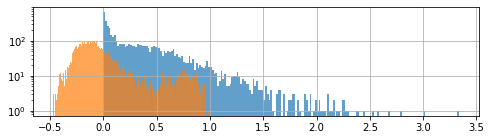

In [30]:
# An example how the new feature vectors compare to the old feature vectors
# As an example, we will compare the second feature vector obtained by the fifth network architecture.
fig, ax = plt.subplots()
pandas.Series(featuresA['MR101'][:,1].flatten()).hist(bins=200, figsize=(8, 2), alpha=0.7)
pandas.Series(featuresB['MR101'][:,1].flatten()).hist(bins=200, figsize=(8, 2), alpha=0.7)
ax.set_yscale('log')

In [31]:
# Prepare the third (C) set of features (tanh scalling, no dimensionality reduction).
def tanh_scalling(features):
    """The third approach."""
    scalled =  numpy.tanh(features)
    print('shape:', scalled.shape)
    return scalled


featuresC = {
    'ResNetV2': tanh_scalling(features1),
    'IncepV3': tanh_scalling(features2),
    'MR50': tanh_scalling(features3),
    'MF50x3': tanh_scalling(features4),
    'MR101': tanh_scalling(features5)
}

shape: (4998, 2048)
shape: (4998, 2048)
shape: (4998, 2048)
shape: (4998, 6144)
shape: (4998, 2048)


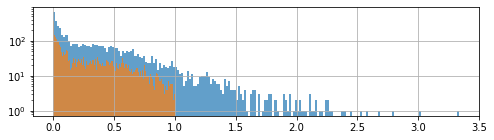

In [32]:
# An example how the new, scalled feature vectors compare to the old feature vectors
# As an example, we will compare the second feature vector obtained by the fifth network architecture.
fig, ax = plt.subplots()
pandas.Series(featuresA['MR101'][:,1].flatten()).hist(bins=200, figsize=(8, 2), alpha=0.7)  # original
pandas.Series(featuresC['MR101'][:,1].flatten()).hist(bins=200, figsize=(8, 2), alpha=0.7)  # 
ax.set_yscale('log')

**Summary:** The main point of that section is that there exist countless methods of preparing feature vectors. Some may work better, some worse. To make sure, that our results are robust, we prepared a several feature vectors, using different models trained on different datasets. In the next section, we will compare the clustering results using those different feature vectors.

## Section 4: Clustering

For the clustering method, we choose K-Means algorithm. We use `k-means++` algorithm to chose the initial positions of the centroids, cf. David Arthur and Sergei Vassilvitskii, _k-Means++: The Advantages of Careful Seeding_ (2007). 

```python
kmeans = sklearn.cluster.KMeans(n_clusters=i, n_init=10, init='k-means++').fit(features)
```

During each execution, we run the algorithm several times (e.g., 10 times) and we chose the results that correspond to the lowest inertia.

To chose the right number of clusters, we look booth at the inertia plot and at the silhouette score. The right number of clusters should correspond to an elbow of the inertia plot and to maximum of the silhouette score. Finally, we look also at the silhouette diagrams, that show both the number of instances each cluster contains and the sorted silhouette coefficients of the instances in each cluster.

 2: inertia = 1380597, silhouette=0.312
 3: inertia = 970184, silhouette=0.365
 4: inertia = 775316, silhouette=0.399
 5: inertia = 603552, silhouette=0.428
 6: inertia = 547798, silhouette=0.366
 7: inertia = 497400, silhouette=0.298


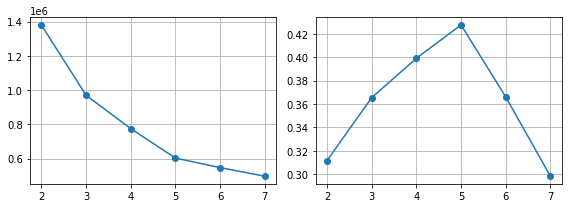

In [33]:
def find_optimal_number_of_clusters(features):
    """Plot the inertia and the silhouette score."""
    x = list(range(2, 8))
    inertia, silhouette = [], []
    for i in x:
        kmeans = sklearn.cluster.KMeans(n_clusters=i, n_init=10, init='k-means++').fit(features)
        score = sklearn.metrics.silhouette_score(features, kmeans.labels_)
        inertia.append(kmeans.inertia_)
        silhouette.append(score)
        print('{:2d}: inertia = {:.0f}, silhouette={:.3f}'.format(i, kmeans.inertia_, score))
        
    # Plot the inertia and the silhouette score
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    axes[0].plot(x, inertia, 'o-'); axes[0].grid()
    axes[1].plot(x, silhouette, 'o-'); axes[1].grid()
    fig.tight_layout()
    plt.show()
    
    
# example
find_optimal_number_of_clusters(features=featuresA['ResNetV2'])

We tested different architectures and different feature scaling approaches. The results are presented in the following table:

**(A) Raw Feature Vectors**

Architecture | Optimal Number of Clusters | Inertia | Silhouette Score
--- | --- | --- | ---
ResNet-V2 	| 5 | 603552 | 0.428
Incep-V3 	| 5 (or 2) | 516890 | 0.256
MR50 		| 3 | 5659395 | 0.508
MR50x3 	| 3 | 13090552 | 0.439
MR101 		| 3 | 5952243 | 0.436


**(B) PCA + Scaling**

Architecture | Optimal Number of Clusters | Inertia | Silhouette Score
--- | --- | --- | ---
ResNet-V2 	| 5 | 1081 | 0.434
Incep-V3 	| 5 (or 2) | 11879 | 0.107
MR50 		| 3 (or 2) | 2454 | 0.429
MR50x3 	| 4 | 2478 | 0.358
MR101 		| 3 | 3077 | 0.357



**(C) tanh scaling**

Architecture | Optimal Number of Clusters | Inertia | Silhouette Score
--- | --- | --- | ---
ResNet-V2 	| 4 | 71274 | 0.326
Incep-V3 	| 5 | 206818 | 0.264
MR50 		| 3 | 176798 | 0.382
MR50x3 	| 3 | 603374 | 0.379
MR101 		| 3 | 204306 | 0.349

**Interpretation:** As we see, the optimal number of clusters is in range of 3 to 5. The first architecture, ResNet-V2, while the simplest from all tested, gives reasonable results. Inception V3 model gives significantly lower silhouette score. Finally, the tanh scaling seems to not help.

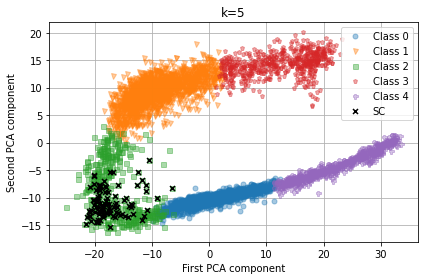

In [34]:
def plot_clusters(fig, ax, k, instances, labels, legend=True):
    """Plot Clusters."""
    global connectivity
    assert k == len(set(labels))
    
    cc = connectivity.sc
    markers = ['o', 'v', 's', 'p', 'P', '*', 'd']
    
    for i in range(k):
        x = instances[labels == i, 0]
        y = instances[labels == i, 1]
        ax.plot(
            x, y, marker=markers[i], linestyle="", label=f'Class {i}',
            markersize=5, alpha=0.4)
    
    # Mark the SC instances
    x = instances[cc == 1, 0]
    y = instances[cc == 1, 1]
    ax.plot(
        x, y, marker='x', linestyle="", label='SC',
        color='black', markeredgewidth=1.5, markersize=5)
    
    ax.title.set_text("k={}".format(k))
    ax.set_xlabel('First PCA component')
    ax.set_ylabel('Second PCA component')
    if legend:
        ax.legend();
    ax.grid(); fig.tight_layout()
    
    
# example
x = featuresA['ResNetV2']
instances = sklearn.decomposition.PCA(n_components=5).fit_transform(x)
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=123).fit(x)

fig, axes = plt.subplots(1, 1)
plot_clusters(fig, axes, k=5, instances=instances, labels=kmeans.labels_)

We computed the clusters for each scaling method and for each generated feature vector. We show the results in the diagram below.

<!-- ![Clustering Results](pics/clustering-results.png) -->

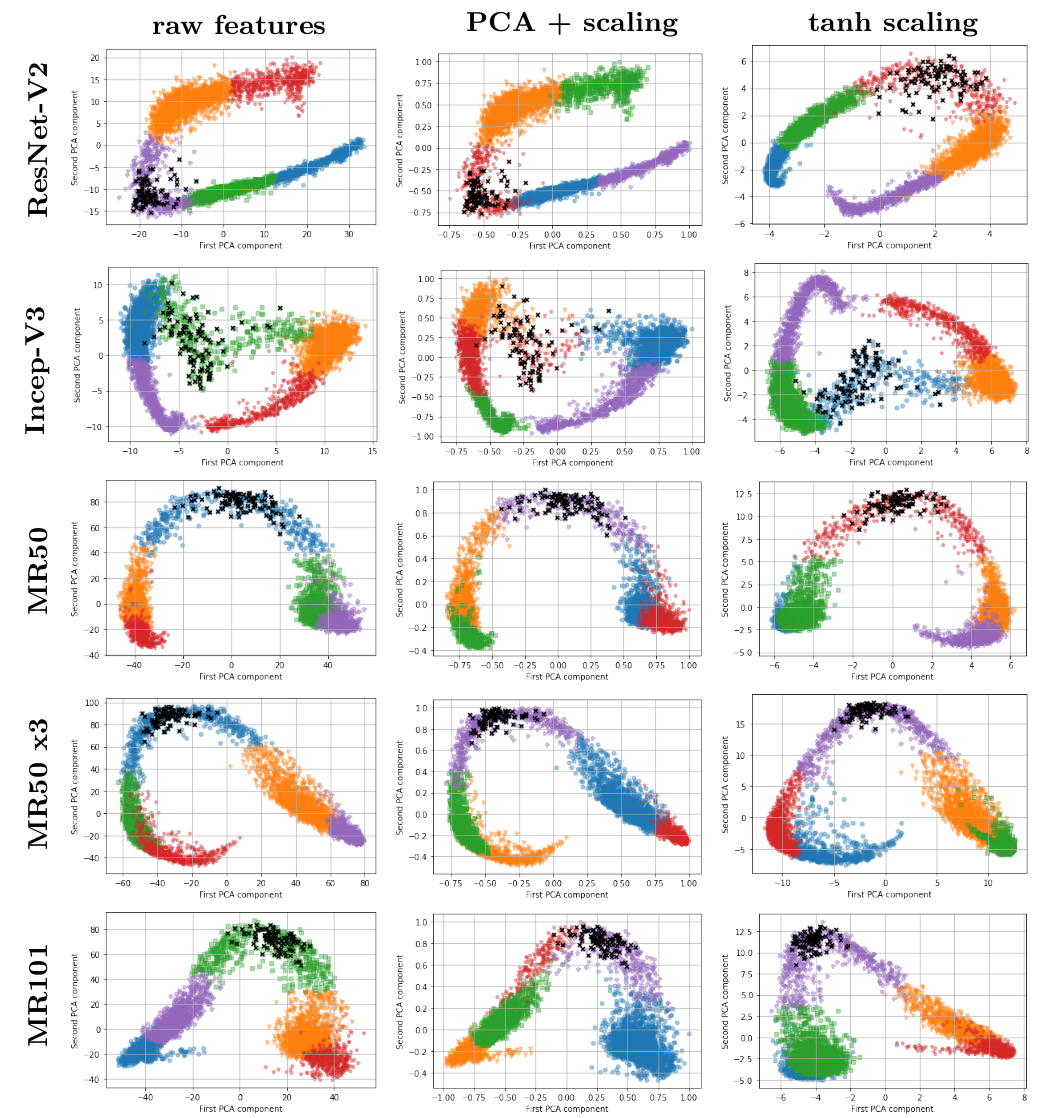

In [35]:
IPython.display.display(IPython.display.Image(os.path.join(DATA_PATH, 'pics/cah-clustering-results.png')))

**Interpretation:** In each case, we set the number of clusters to 5. As we can see, the results are quite robust - as there is no big qualitative difference between different network architectures.

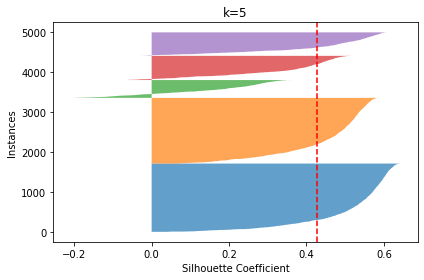

In [36]:
def print_silhouette_diagram(fig, ax, k, x, labels):
    """Print the Silhouette Diagram"""
    assert k == len(set(labels))

    silhouette_coefficients = sklearn.metrics.silhouette_samples(x, labels)
    score = sklearn.metrics.silhouette_score(x, labels)

    pos = 0
    for i in range(k):
        coeffs = silhouette_coefficients[labels == i]
        coeffs.sort()
        ax.fill_betweenx(numpy.arange(pos, pos + len(coeffs)), 0, coeffs, alpha=0.7)
        pos += len(coeffs)
        
    ax.axvline(x=score, color="red", linestyle="--")
    ax.title.set_text("k={}".format(k))
    ax.set_ylabel("Instances")
    ax.set_xlabel("Silhouette Coefficient")
    fig.tight_layout() 
    

# example
x = featuresA['ResNetV2']
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=123).fit(x)

fig, axes = plt.subplots(1, 1)
print_silhouette_diagram(fig, axes, k=5, x=x, labels=kmeans.labels_)

Despite the fact that the silhouette score was maximal for five clusters, we might argue that the number of clusters k=5 is not necessarily the optimal number. Note, that one silhouette coefficients for one of the class are below the average silhouette score - which means, that the instances from that class are quite dissimilar to each other, and either that class should be split or their instances could be added to other clusters.

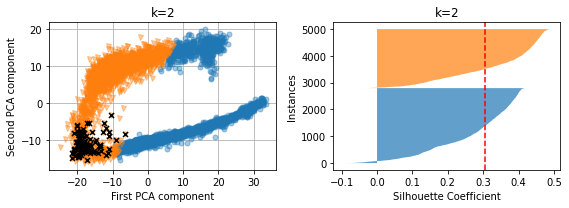

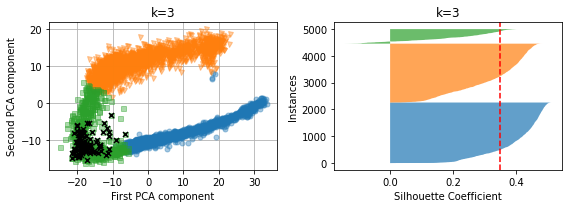

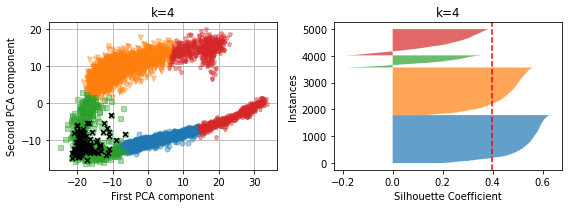

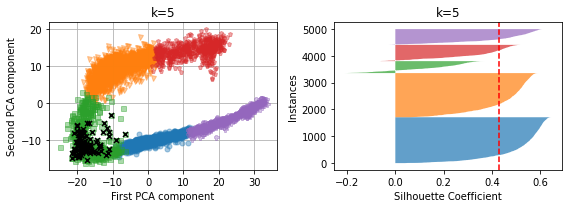

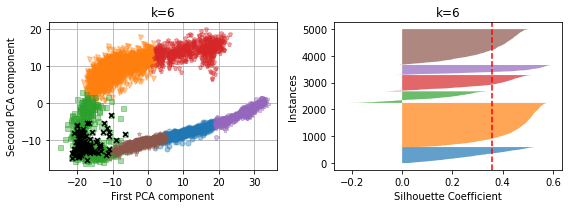

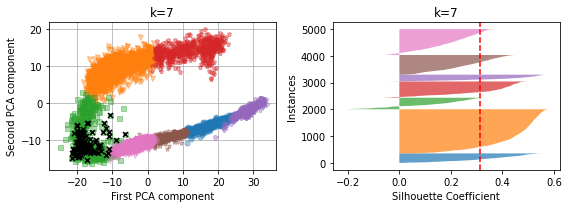

In [37]:
# test different number of clusters
x = featuresA['ResNetV2']

for k in (2, 3, 4, 5, 6, 7):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init='k-means++', random_state=123).fit(x)
    instances = sklearn.decomposition.PCA(n_components=k).fit_transform(x)

    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    plot_clusters(fig, axes[0], k=k, instances=instances, labels=kmeans.labels_, legend=False)
    print_silhouette_diagram(fig, axes[1], k=k, x=x, labels=kmeans.labels_)
    plt.show()

**Interpretation:** From the Silhouette diagrams, we can get a sense that either k=2 or k=5, or even k=6 would be an accepted number of clusters. We see also, that when we increase the number of clusters, we tend to divide the "arms" into smaller regions. This might indicate either that there is a hierarchy of clusters: larger clusters can be divided into smaller sub-clusters. Or that the character of our input situated in the "arms" changes in more-less continuous way.

Additionally, we see that the cluster that consists of the "elbow" (the green cluster), has small number of relatively dis-similar objects. This indicated, that the characteristics of objects change rapidly in that region (when going from one instance to another). Using dark crosses, we marked all SC instances. They all belong to the green cluster. We know that SC instances happen when dis-connected regions of our phase start to merge into macroscopic structures. Our method can pick-up instances that correspond to that phenomenon.

### Class Examples

We can plot class examples.

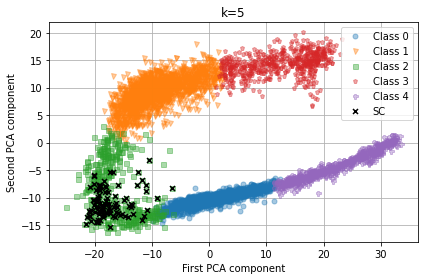

In [38]:
x = featuresA['ResNetV2']
instances = sklearn.decomposition.PCA(n_components=5).fit_transform(x)
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=123).fit(x)

fig, axes = plt.subplots(1, 1)
plot_clusters(fig, axes, k=5, instances=instances, labels=kmeans.labels_)

In [39]:
def plot_classes(img, labels, width=5):
    """Plot figures."""
    classes = set(labels)
    
    for c in classes:
        selected = img[labels == c][:width]

        fig, axes = plt.subplots(1, width, dpi=80, figsize=(width, 1))
        for i, m in enumerate(selected):
            axes[i%width].imshow(m)
            axes[i%width].axis('off')
            if i == 0:
                axes[i%width].set_title(f'Class {c}')
            
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

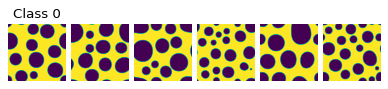

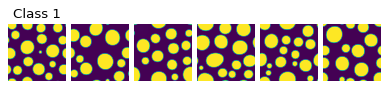

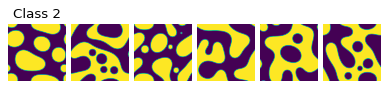

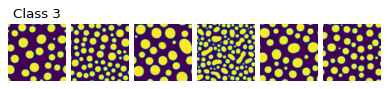

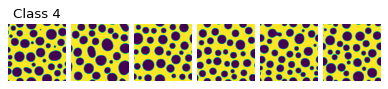

In [40]:
plot_classes(data, labels=kmeans.labels_, width=6)

In [41]:
def plot_in_parameters_space(fig, ax, xname, yname, k, labels):
    """Plot in the parameters space."""
    global parameters, connectivity
    markers = ['o', 'v', 's', 'p', 'P', '*', 'd']
    
    for i in range(k):
        x = parameters[xname][labels == i]
        y = parameters[yname][labels == i]
        ax.plot(x, y, marker=markers[i], linestyle="", label=f'Class {i}', markersize=3, alpha=0.45)
    
    # Mark SC instances
    x = parameters[xname][connectivity.sc == 1]
    y = parameters[yname][connectivity.sc == 1]
    ax.plot(x, y, marker='x', linestyle="", label='SC', color='black', markeredgewidth=2, markersize=7)

    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    fig.tight_layout()

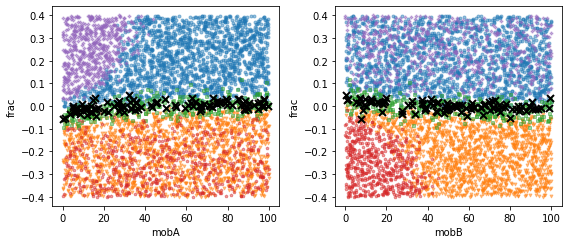

In [42]:
x = featuresA['ResNetV2']
kmeans = sklearn.cluster.KMeans(n_clusters=5, n_init=1, init='k-means++', random_state=123).fit(x)

fig, axes = plt.subplots(1, 2, figsize=(8,3.5))
plot_in_parameters_space(fig, axes[0], 'mobA', 'frac', k=5, labels=kmeans.labels_)
plot_in_parameters_space(fig, axes[1], 'mobB', 'frac', k=5, labels=kmeans.labels_)

**Interpretation:** Each class can be logically interpreted.
 - Class 4 consists of examples were positive phase is dominant and mobility of the positive phase is small.
 - Class 0 consists of examples were positive phase is dominant and mobility of the positive phase is large.
 - Class 2 consists of examples were fraction of the positive and negative phase is equal. Those conditions correspond to situation when dis-connected regions of phase (either the positive or the negative one) merge into connected structures. This happen irrelevant of the value of the mobility (the Universality property of the system). 
 - Class 1 consists of examples were negative phase is dominant and mobility of the negative phase is large.
 - Class 3 consists of examples were negative phase is dominant and mobility of the negative phase is small.

## Section 5: Learning by Confusion

From the analysis above, we see that the cluster that contain SC examples consists of instances that are quite dis-similar to each other. This can indicate, that the visual characteristics of the instances change rapidly in a narrow region when we go from `frac` negative to positive values or vice versa.  We would like to study that transition a bit more. We adopt the scheme from Evert P. L. van Nieuwenburg, Ye-Hua Liu, and Sebastian D. Huber, _Learning phase transitions by confusion_, Nature Physics volume **13**, 435 (2017).

Nieuwenburg used PCA to reduce the dimensionality of the input to 10. Next, he used a simple forward-fed neural network with 80 sigmoid neurons in a single hidden layer.

We tested (own work, not presented here), that we can use the raw imput and we can use a CNN neural network and we get similar results. However, here we follow Nieuwenburg's prescription more closely. We use the feature vectors as the input, we will reduce its dimensionality using PCA to 16, next we will use a simple forward-fed neural network with 128 sigmoid neurons in a single hidden layer (8x the input dimension).

To prevent our network from overfitting, we will add dropout and we will add callback that stop training when our validation loss function doesn't improve.

In [43]:
# Create training and validation set index
indexes = list(range(len(data)))

random.seed(123)
random.shuffle(indexes)

train_n = int(len(data)*0.8)
train_idx = numpy.array(indexes[:train_n])
val_idx = numpy.array(indexes[train_n:])

train_idx[:5], train_idx.shape, val_idx[:5], val_idx.shape

(array([1823, 3764, 2702,  464,  994]),
 (3998,),
 array([1095, 1042, 2876, 3791, 3932]),
 (1000,))

In [44]:
# Create training and validation dataset
reduced = sklearn.decomposition.PCA(n_components=16).fit_transform(featuresA['ResNetV2'])

train_x = reduced[train_idx]
train_p = parameters.to_numpy()[train_idx]

val_x = reduced[val_idx]
val_p = parameters.to_numpy()[val_idx]

train_x.shape, train_p.shape, val_x.shape, val_p.shape

((3998, 16), (3998, 3), (1000, 16), (1000, 3))

In [45]:
# Define metrics
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'), 
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),  # accuracy
      tensorflow.keras.metrics.Precision(name='precission'),  # precission
      tensorflow.keras.metrics.Recall(name='recall'),  # recall
      tensorflow.keras.metrics.AUC(name='auc'),
]

Treshold -0.4: steps [5, 5, 4, 5, 5]; <acc> 1.000; <auc> 1.000
Treshold -0.389: steps [5, 5, 7, 6, 5]; <acc> 0.989; <auc> 0.999
Treshold -0.377: steps [8, 8, 8, 7, 8]; <acc> 0.971; <auc> 0.998
Treshold -0.366: steps [9, 8, 8, 8, 7]; <acc> 0.968; <auc> 0.997
Treshold -0.354: steps [9, 9, 8, 9, 9]; <acc> 0.959; <auc> 0.996
Treshold -0.343: steps [9, 10, 11, 9, 7]; <acc> 0.960; <auc> 0.995


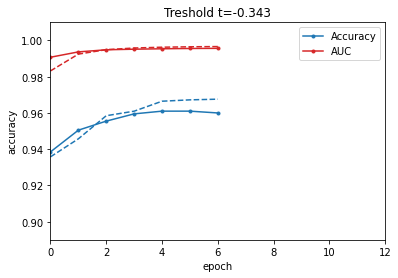

Treshold -0.331: steps [7, 7, 8, 8, 7]; <acc> 0.968; <auc> 0.996
Treshold -0.32: steps [8, 9, 7, 5, 5]; <acc> 0.962; <auc> 0.996
Treshold -0.309: steps [8, 7, 8, 7, 9]; <acc> 0.961; <auc> 0.996
Treshold -0.297: steps [7, 9, 8, 8, 8]; <acc> 0.965; <auc> 0.996
Treshold -0.286: steps [8, 8, 8, 9, 7]; <acc> 0.968; <auc> 0.996
Treshold -0.274: steps [7, 7, 7, 6, 7]; <acc> 0.960; <auc> 0.995
Treshold -0.263: steps [6, 5, 9, 6, 7]; <acc> 0.955; <auc> 0.993
Treshold -0.251: steps [6, 5, 5, 5, 6]; <acc> 0.950; <auc> 0.993
Treshold -0.24: steps [5, 6, 5, 5, 7]; <acc> 0.950; <auc> 0.993
Treshold -0.229: steps [7, 6, 6, 5, 5]; <acc> 0.962; <auc> 0.995
Treshold -0.217: steps [5, 7, 5, 5, 5]; <acc> 0.963; <auc> 0.996
Treshold -0.206: steps [8, 8, 9, 7, 6]; <acc> 0.971; <auc> 0.997
Treshold -0.194: steps [7, 7, 8, 7, 7]; <acc> 0.965; <auc> 0.997
Treshold -0.183: steps [7, 6, 7, 7, 7]; <acc> 0.964; <auc> 0.996
Treshold -0.171: steps [7, 7, 5, 6, 7]; <acc> 0.961; <auc> 0.996
Treshold -0.16: steps [8, 6

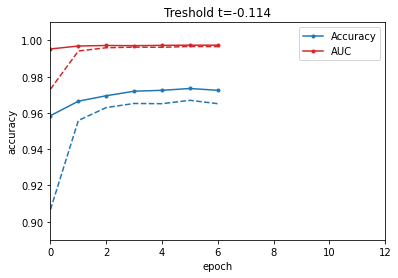

Treshold -0.103: steps [7, 8, 6, 7, 7]; <acc> 0.965; <auc> 0.996
Treshold -0.0914: steps [6, 7, 5, 4, 8]; <acc> 0.960; <auc> 0.996
Treshold -0.08: steps [7, 6, 7, 5, 8]; <acc> 0.967; <auc> 0.997
Treshold -0.0686: steps [8, 6, 7, 6, 7]; <acc> 0.975; <auc> 0.998
Treshold -0.0571: steps [6, 8, 7, 8, 8]; <acc> 0.975; <auc> 0.998
Treshold -0.0457: steps [8, 6, 8, 8, 8]; <acc> 0.979; <auc> 0.998
Treshold -0.0343: steps [5, 7, 7, 6, 5]; <acc> 0.976; <auc> 0.998
Treshold -0.0229: steps [5, 6, 7, 6, 6]; <acc> 0.976; <auc> 0.998
Treshold -0.0114: steps [5, 6, 6, 6, 4]; <acc> 0.976; <auc> 0.999
Treshold 0.0: steps [7, 6, 6, 5, 6]; <acc> 0.977; <auc> 0.999
Treshold 0.0114: steps [7, 6, 7, 7, 6]; <acc> 0.982; <auc> 0.999
Treshold 0.0229: steps [6, 6, 7, 6, 6]; <acc> 0.982; <auc> 0.999
Treshold 0.0343: steps [5, 6, 7, 8, 4]; <acc> 0.977; <auc> 0.998
Treshold 0.0457: steps [5, 5, 5, 5, 6]; <acc> 0.973; <auc> 0.998
Treshold 0.0571: steps [8, 6, 7, 6, 5]; <acc> 0.969; <auc> 0.997
Treshold 0.0686: steps

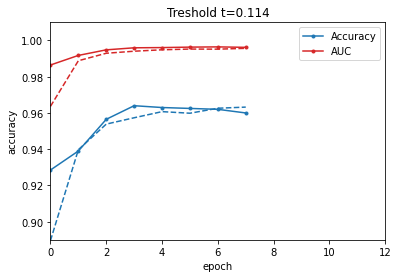

Treshold 0.126: steps [7, 8, 7, 6, 8]; <acc> 0.957; <auc> 0.995
Treshold 0.137: steps [7, 8, 9, 8, 5]; <acc> 0.963; <auc> 0.995
Treshold 0.149: steps [9, 9, 8, 7, 10]; <acc> 0.962; <auc> 0.995
Treshold 0.16: steps [9, 9, 9, 8, 7]; <acc> 0.963; <auc> 0.995
Treshold 0.171: steps [10, 9, 8, 8, 8]; <acc> 0.967; <auc> 0.995
Treshold 0.183: steps [8, 10, 6, 8, 7]; <acc> 0.965; <auc> 0.994
Treshold 0.194: steps [7, 9, 7, 8, 7]; <acc> 0.962; <auc> 0.994
Treshold 0.206: steps [6, 9, 8, 9, 6]; <acc> 0.958; <auc> 0.995
Treshold 0.217: steps [11, 9, 9, 10, 9]; <acc> 0.955; <auc> 0.995
Treshold 0.229: steps [8, 7, 9, 8, 6]; <acc> 0.955; <auc> 0.994
Treshold 0.24: steps [8, 7, 8, 8, 8]; <acc> 0.955; <auc> 0.994
Treshold 0.251: steps [7, 10, 10, 7, 8]; <acc> 0.955; <auc> 0.995
Treshold 0.263: steps [8, 8, 7, 6, 7]; <acc> 0.957; <auc> 0.995
Treshold 0.274: steps [9, 8, 8, 8, 8]; <acc> 0.962; <auc> 0.996
Treshold 0.286: steps [8, 11, 11, 9, 9]; <acc> 0.968; <auc> 0.997
Treshold 0.297: steps [11, 9, 11,

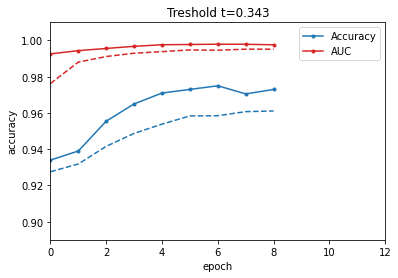

Treshold 0.354: steps [8, 8, 10, 9, 10]; <acc> 0.968; <auc> 0.997
Treshold 0.366: steps [9, 7, 10, 9, 8]; <acc> 0.968; <auc> 0.997
Treshold 0.377: steps [11, 10, 9, 8, 9]; <acc> 0.973; <auc> 0.998
Treshold 0.389: steps [9, 8, 10, 10, 9]; <acc> 0.985; <auc> 0.999
Treshold 0.4: steps [5, 5, 4, 5, 6]; <acc> 1.000; <auc> 1.000


In [46]:
# Define labels for each treshold and measure the performance of the neural network
create_labels = lambda pp, treshold: numpy.array([[1, 0] if p > treshold else [0, 1] for p in pp[:,-1]])

global_log = []
for i, t in enumerate(numpy.linspace(-0.4, 0.4, 71)):
    # Create Labels
    train_y = create_labels(train_p, treshold=t)
    val_y = create_labels(val_p, treshold=t)

    experiment_logs = []
    for j in range(5):  # repeat the experiment a few times
        # Build Network
        model = tensorflow.keras.Sequential()
        model.add(tensorflow.keras.layers.Dense(128, activation='sigmoid'))
        model.add(tensorflow.keras.layers.Dropout(0.2))
        model.add(tensorflow.keras.layers.Dense(2, activation='sigmoid'))
        model.build([None, 16])

        # Compile
        model.compile(
            optimizer=tensorflow.keras.optimizers.Adam(),
            loss=tensorflow.keras.losses.BinaryCrossentropy(),
            metrics=METRICS
        )

        # Train
        callback = tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=1, min_delta=0.001
        )
        log =  model.fit(
            train_x, train_y, epochs=15, verbose=0,
            validation_data=(val_x, val_y), callbacks=[callback]
        )
    
        # Save
        experiment_logs.append(log.history)
        
    # Add to the global log.
    global_log.append(experiment_logs)
    
    # Print
    print(
        'Treshold {:.3}: steps {}; <acc> {:.3f}; <auc> {:.3f}'.format(
            t, [len(l['val_loss']) for l in experiment_logs],
            numpy.array([l['val_accuracy'][-1] for l in experiment_logs]).mean(),
            numpy.array([l['val_auc'][-1] for l in experiment_logs]).mean()
        )
    )
    
    # Plot Training Curve (not every step)
    log = experiment_logs[-1]
    if i%20 == 5:
        plt.plot(log['val_accuracy'], '.-', color='tab:blue', label='Accuracy')
        plt.plot(numpy.array(log['accuracy']), '--', color='tab:blue')
        plt.plot(log['val_auc'], '.-', label='AUC', color='tab:red')
        plt.plot(numpy.array(log['auc']), '--', color='tab:red')
        plt.title(f'Treshold t={t:.3f}')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.ylim([0.89, 1.01])
        plt.xlim([0, 12])
        plt.legend()
        plt.show()

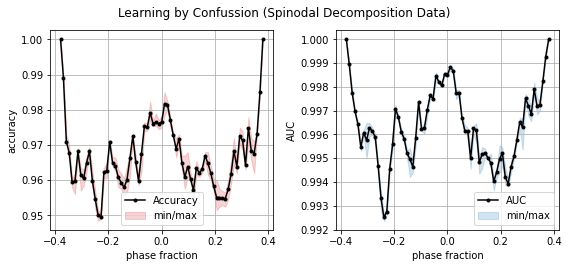

In [47]:
x = numpy.linspace(-0.38, 0.38, 71)
fig, axes = plt.subplots(1, 2, figsize=(8,3.5))

# Plot Accuracy
acc = numpy.array([[l['val_accuracy'][-1] for l in log] for log in global_log])
axes[0].plot(x, acc.mean(axis=-1), '.-', color='black', label='Accuracy')
axes[0].fill_between(x, acc.min(axis=-1), acc.max(axis=-1), color='tab:red', alpha=0.2, label='min/max')
axes[0].set_ylabel('accuracy'); axes[0].set_xlabel('phase fraction')
axes[0].legend(); axes[0].grid(); fig.tight_layout()

# Plot AUC
auc = numpy.array([[l['val_auc'][-1] for l in log] for log in global_log])
axes[1].plot(x, auc.mean(axis=-1), '.-', color='black', label='AUC')
axes[1].fill_between(x, auc.min(axis=-1), auc.max(axis=-1), color='tab:blue', alpha=0.2, label='min/max')
axes[1].set_ylabel('AUC'); axes[1].set_xlabel('phase fraction')
axes[1].legend(); axes[1].grid(); fig.tight_layout()

plt.suptitle(f'Learning by Confussion (Spinodal Decomposition Data)', y=1.05)
plt.show()

### Fitting Gaussian to find the exact transition

We can fit a Gaussina to the data, finding approximately the parameter value for which we have a transition.

In [48]:
def gaussian(x, amplitude, mean, stddev, bias):
    """Return gaussian function in 1D."""
    return amplitude*numpy.exp(-((x - mean)/(4*stddev))**2) + bias


# Restrick yourself only to values close to the peak
peak_x = x[20:51]
peak_y = auc[20:51]

# Fit gaussina
popt, _ = scipy.optimize.curve_fit(
    gaussian, peak_x, peak_y.mean(axis=-1),
    p0=[1, 0, 0.01, 1]
)

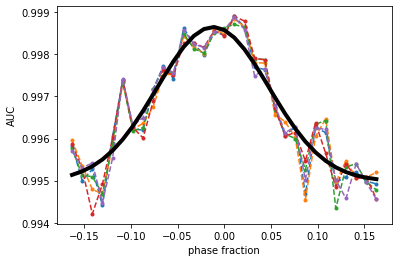

In [49]:
# Show results
plt.plot(peak_x, peak_y, '.--')
plt.plot(peak_x, gaussian(peak_x, *popt), 'k-', linewidth=4)
plt.xlabel('phase fraction'); plt.ylabel('AUC')
plt.show()

In [50]:
# Find the parameter value that corresponds to the peak
popt  # aplitude, mean value, std, bias

array([ 0.00366395, -0.01183527,  0.02118767,  0.99498328])

## Summary

We tested several feature vector representations. We found that the clustering results were stable with respect to the choice of different network architectures. We determined the optimal number of clusters. There are two main regions, within each region the output characteristics change in a continuous manner. We described a region in latent space that corresponds to situation where the phase-regions merge together, creating macroscopic structures. We presented an universality behavior of the output in this region. Using the learning by confusion schema, we were able to determine the value of the critical parameter to be `frac = -0.01 +- 0.02`, what is in agreement with our intuition and with the symmetry of the problem.